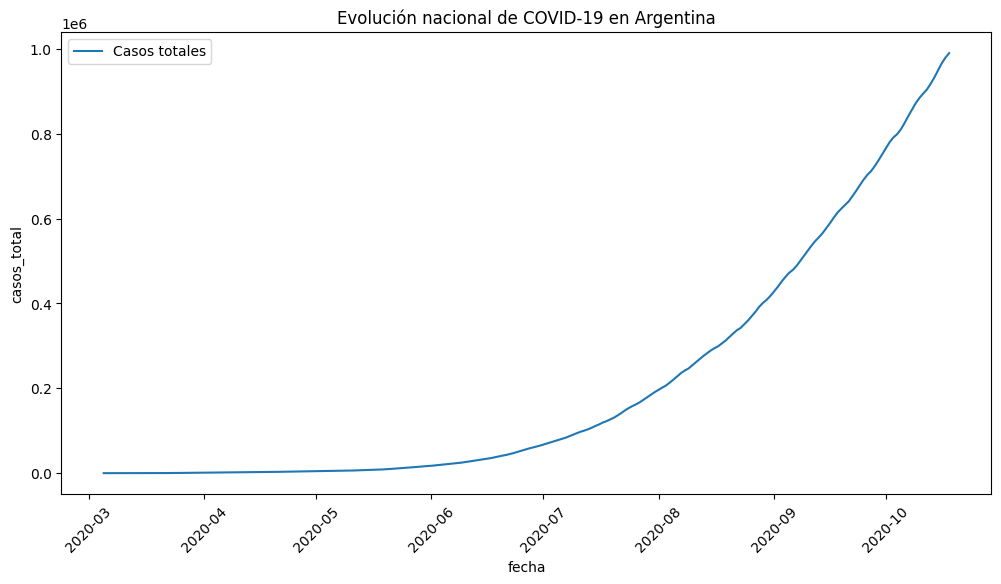

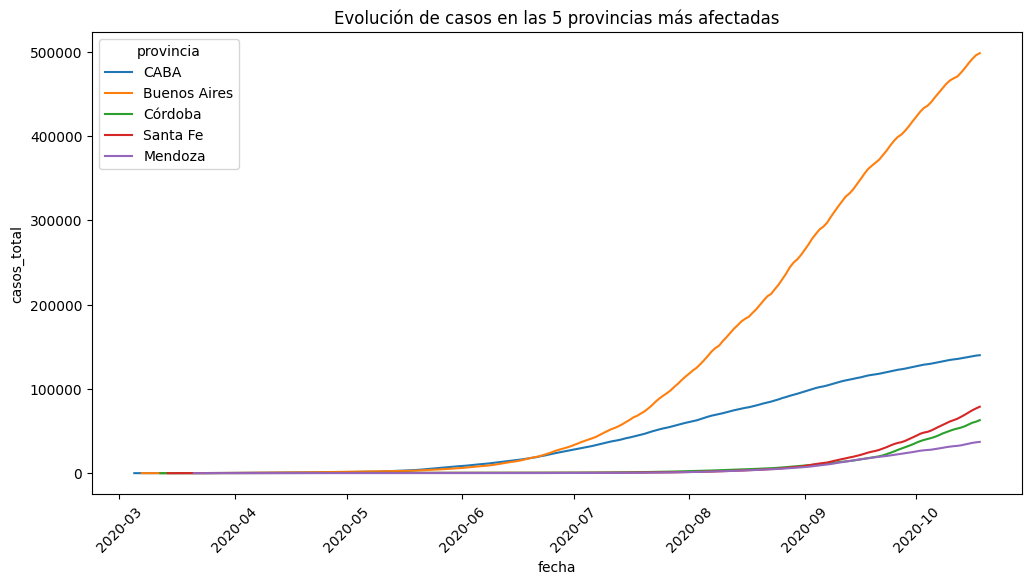

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos nacionales
df_nacional = pd.read_csv('Argentina-covid19.csv', parse_dates=['fecha'])
df_provincias = pd.read_csv('Argentina-covid19-por-provincia.csv', parse_dates=['fecha'])

# 1. Evolución nacional de casos y muertes
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_nacional, x='fecha', y='casos_total', label='Casos totales')
plt.title('Evolución nacional de COVID-19 en Argentina')
plt.xticks(rotation=45)
plt.show()



# 3. Casos por provincia (top 5)
top_provincias = df_provincias.groupby('provincia')['casos_total'].max().sort_values(ascending=False).head(5).index
df_top = df_provincias[df_provincias['provincia'].isin(top_provincias)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top, x='fecha', y='casos_total', hue='provincia')
plt.title('Evolución de casos en las 5 provincias más afectadas')
plt.xticks(rotation=45)
plt.show()

Parámetros estimados: n = 3.19, p = 0.01


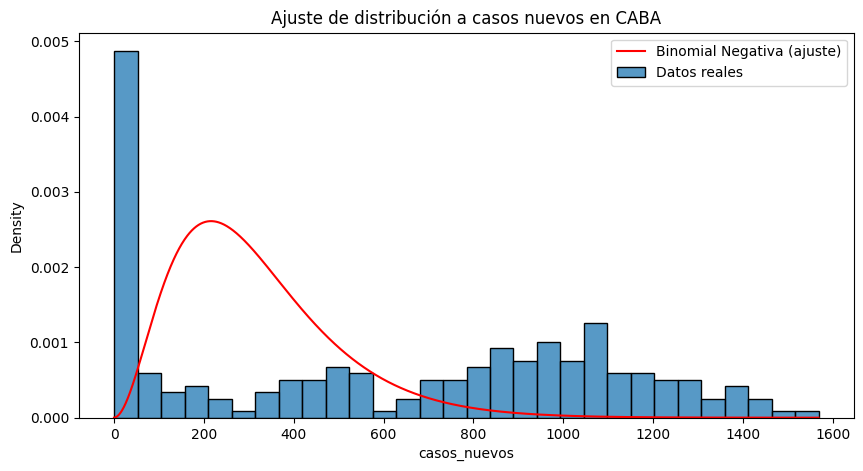

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import nbinom
from scipy.optimize import minimize

# Cargar datos (asegúrate de que la ruta sea correcta)
df_provincias = pd.read_csv('Argentina-covid19-por-provincia.csv', parse_dates=['fecha'])

# Filtrar datos de CABA y limpiar valores faltantes
caba_casos = df_provincias[df_provincias['provincia'] == 'CABA']['casos_nuevos'].dropna().astype(int)

# Función para calcular log-verosimilitud negativa
def neg_log_likelihood(params, data):
    n, p = params
    return -np.sum(nbinom.logpmf(data, n, p))

# Estimación inicial y restricciones
initial_guess = [1.0, 0.5]
bounds = [(0.1, 100), (0.01, 0.99)]  # n > 0, 0 < p < 1

# Optimización para encontrar los parámetros
result = minimize(
    neg_log_likelihood,
    initial_guess,
    args=(caba_casos),
    bounds=bounds,
    method='L-BFGS-B'
)

n_hat, p_hat = result.x
print(f"Parámetros estimados: n = {n_hat:.2f}, p = {p_hat:.2f}")

# Visualización del ajuste
plt.figure(figsize=(10, 5))
sns.histplot(caba_casos, stat='density', label='Datos reales', bins=30)
x = np.arange(0, caba_casos.max() + 1)
plt.plot(x, nbinom.pmf(x, n_hat, p_hat), 'r-', label='Binomial Negativa (ajuste)')
plt.title('Ajuste de distribución a casos nuevos en CABA')
plt.legend()
plt.show()

In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Cargar datos nacionales
df_nacional = pd.read_csv('Argentina-covid19.csv', parse_dates=['fecha'])

# Calcular variables SIR
df_nacional['I'] = df_nacional['casos_total'] - df_nacional['alta_total'] - df_nacional['muertes_total']
df_nacional['R'] = df_nacional['alta_total']
poblacion_argentina = 45_000_000  # Aproximación (ajusta según datos reales)
df_nacional['S'] = poblacion_argentina - df_nacional['I'] - df_nacional['R']

# Filtrar datos iniciales (ej: primeros 90 días)
df_sir = df_nacional[['fecha', 'S', 'I', 'R']].dropna().iloc[:90]

In [9]:
def modelo_sir(params, datos_reales):
    beta, gamma = params
    S, I, R = datos_reales['S'], datos_reales['I'], datos_reales['R']
    N = S + I + R
    dS = -beta * S * I / N
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])

def error(params, datos_reales):
    # Calcular diferencias entre modelo y datos reales
    S, I, R = datos_reales['S'], datos_reales['I'], datos_reales['R']
    dS_real = np.diff(S, prepend=S.iloc[0])
    dI_real = np.diff(I, prepend=I.iloc[0])
    dR_real = np.diff(R, prepend=R.iloc[0])
    dS_model, dI_model, dR_model = modelo_sir(params, datos_reales)
    return np.sum((dS_real - dS_model)**2 + (dI_real - dI_model)**2 + (dR_real - dR_model)**2)

# Estimación inicial y optimización
initial_guess = [0.2, 0.1]  # Valores típicos iniciales para beta y gamma
result = minimize(error, initial_guess, args=(df_sir), method='L-BFGS-B', bounds=[(0.001, 1), (0.001, 1)])
beta_hat, gamma_hat = result.x
print(f"Parámetros estimados: β = {beta_hat:.4f}, γ = {gamma_hat:.4f}")
print(f"Número reproductivo básico R0 = {beta_hat / gamma_hat:.2f}")

Parámetros estimados: β = 0.0678, γ = 0.0216
Número reproductivo básico R0 = 3.14



=== AJUSTANDO PARÁMETROS ===
Parámetros óptimos: β = 0.170874, γ = 0.056993
R0 óptimo: 3.00


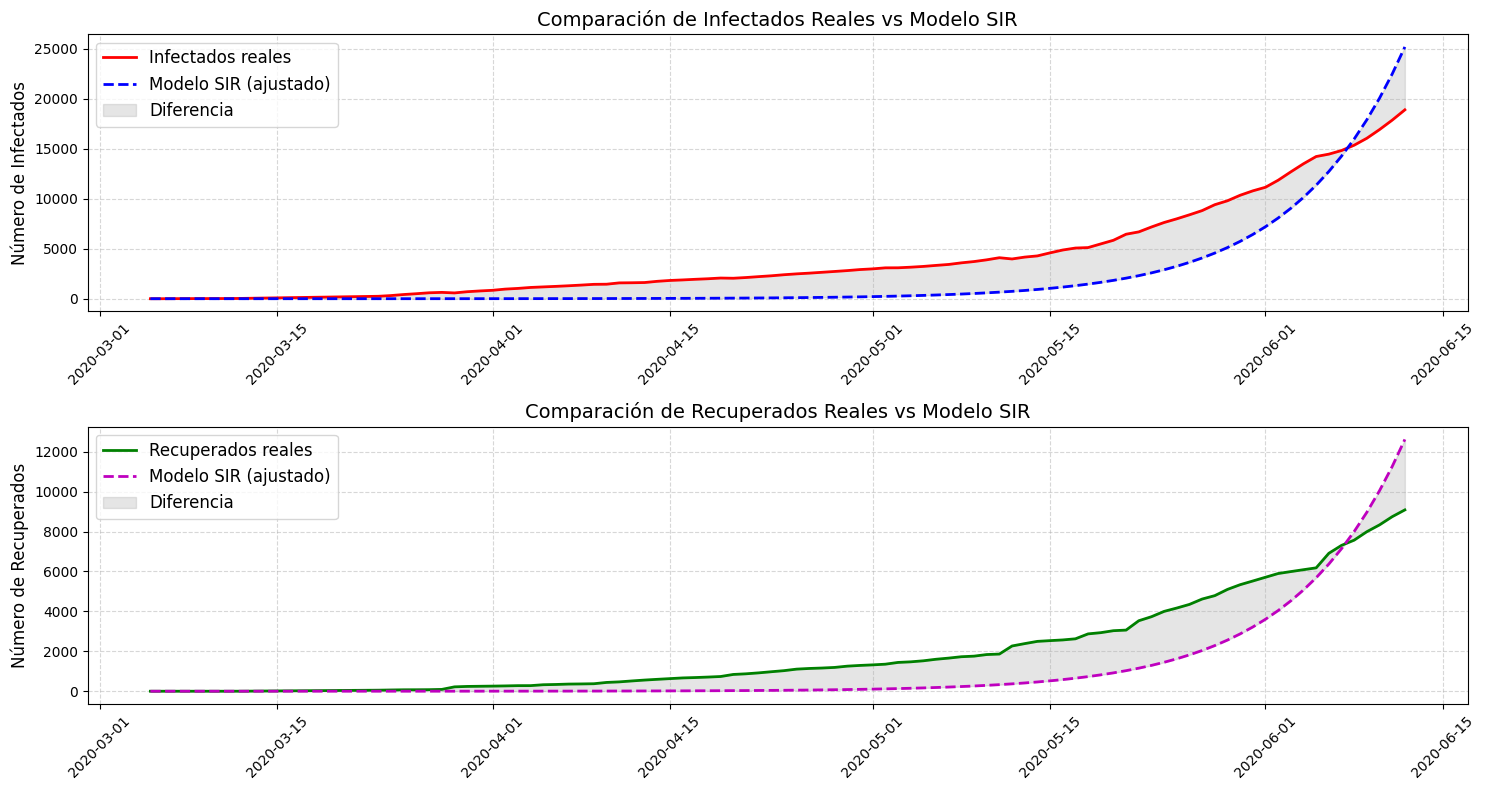


Error absoluto medio - Infectados: 2350.56
Error absoluto medio - Recuperados: 1091.02

Comparación en puntos clave:
     Fecha  Infectados Reales  Infectados Modelo  Diferencia I  Recuperados Reales  Recuperados Modelo  Diferencia R
2020-03-05                1.0           1.000000      0.000000                 0.0            0.000000      0.000000
2020-04-02              963.0           7.766776    955.233224               266.0            3.386501    262.613499
2020-04-20             2049.0          60.322666   1988.677334               840.0           29.688668    810.311332
2020-05-08             3590.0         468.503201   3121.496799              1728.0          233.969409   1494.030591
2020-05-26             8395.0        3638.183423   4756.816577              4349.0         1820.430615   2528.569385


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

def modelo_sir(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def simular_sir(beta, gamma, S0, I0, R0, t):
    N = S0 + I0 + R0
    sol = odeint(modelo_sir, [S0, I0, R0], t, args=(beta, gamma, N))
    return sol.T  # Devuelve S, I, R por separado

def calcular_error(params, datos_reales, t):
    beta, gamma = params
    S0, I0, R0 = datos_reales['S'].iloc[0], datos_reales['I'].iloc[0], datos_reales['R'].iloc[0]

    S_sim, I_sim, R_sim = simular_sir(beta, gamma, S0, I0, R0, t)

    # Error ponderado (mayor peso a infectados)
    error_I = np.sum((I_sim - datos_reales['I'])**2)
    error_R = np.sum((R_sim - datos_reales['R'])**2)

    return 0.7*error_I + 0.3*error_R  # 70% peso a infectados, 30% a recuperados

# Ajuste de parámetros
print("\n=== AJUSTANDO PARÁMETROS ===")
t = np.arange(len(df_sir))
initial_guess = [0.2, 0.1]  # Valores iniciales más realistas
bounds = [(0.001, 1.0), (0.001, 0.5)]  # Rangos razonables

result = minimize(
    calcular_error,
    initial_guess,
    args=(df_sir, t),
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000}
)

beta_opt, gamma_opt = result.x
print(f"Parámetros óptimos: β = {beta_opt:.6f}, γ = {gamma_opt:.6f}")
print(f"R0 óptimo: {beta_opt/gamma_opt:.2f}")

# Simulación con parámetros óptimos
S_sim, I_sim, R_sim = simular_sir(beta_opt, gamma_opt,
                                 df_sir['S'].iloc[0],
                                 df_sir['I'].iloc[0],
                                 df_sir['R'].iloc[0], t)

# Visualización mejorada
plt.figure(figsize=(15, 8))

# Gráfico de Infectados
plt.subplot(2, 1, 1)
plt.plot(df_sir['fecha'], df_sir['I'], 'r-', label='Infectados reales', linewidth=2)
plt.plot(df_sir['fecha'], I_sim, 'b--', label='Modelo SIR (ajustado)', linewidth=2)
plt.fill_between(df_sir['fecha'], df_sir['I'], I_sim, color='gray', alpha=0.2, label='Diferencia')
plt.title('Comparación de Infectados Reales vs Modelo SIR', fontsize=14)
plt.ylabel('Número de Infectados', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Gráfico de Recuperados
plt.subplot(2, 1, 2)
plt.plot(df_sir['fecha'], df_sir['R'], 'g-', label='Recuperados reales', linewidth=2)
plt.plot(df_sir['fecha'], R_sim, 'm--', label='Modelo SIR (ajustado)', linewidth=2)
plt.fill_between(df_sir['fecha'], df_sir['R'], R_sim, color='gray', alpha=0.2, label='Diferencia')
plt.title('Comparación de Recuperados Reales vs Modelo SIR', fontsize=14)
plt.ylabel('Número de Recuperados', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Métricas de error
error_I = np.mean(np.abs(I_sim - df_sir['I']))
error_R = np.mean(np.abs(R_sim - df_sir['R']))
print(f"\nError absoluto medio - Infectados: {error_I:.2f}")
print(f"Error absoluto medio - Recuperados: {error_R:.2f}")

# Comparación de curvas
comparacion = pd.DataFrame({
    'Fecha': df_sir['fecha'],
    'Infectados Reales': df_sir['I'],
    'Infectados Modelo': I_sim,
    'Diferencia I': df_sir['I'] - I_sim,
    'Recuperados Reales': df_sir['R'],
    'Recuperados Modelo': R_sim,
    'Diferencia R': df_sir['R'] - R_sim
})

print("\nComparación en puntos clave:")
print(comparacion.iloc[::len(comparacion)//5].to_string(index=False))  # Muestra 5 puntos equidistantes

In [46]:
# Ejecuta esto y dime el resultado:
import pandas as pd
df = pd.read_csv('Argentina-covid19.csv')
print("Columnas nacionales:", df.columns.tolist())
print("Ejemplo de fecha:", df.iloc[0]['fecha'])  # Reemplaza 'fecha' por la columna correcta si es diferente

Columnas nacionales: ['fecha', 'dia_cuarentena', 'casos_nuevos', 'casos_total', 'activos', 'alta_total', 'alta_nuevos', 'muertes_total', 'muertes_nuevos', 'tests_realizados_total', 'tests_realizados_nuevos', 'test_por_millon_hab', 'UTI_internados', 'UTI_%Nacion', 'UTI_%AMBA', '%mujer', '%varon', 'mujer_total', 'varon_total', 'franja_etaria', 'edad_prom', 'importados_total', 'importados_nuevos', 'local_total', 'local_nuevos', 'comunitario_total', 'comunitario_nuevos', 'en_investigacion_total', 'en_investigacion_nuevos', 'alta_definitiva', 'descartados_total', 'descartados_nuevos', 'observaciones']
Ejemplo de fecha: 2020-03-05


In [47]:
df_prov = pd.read_csv('Argentina-covid19-por-provincia.csv')
print("Columnas provinciales:", df_prov.columns.tolist())
print("Ejemplo fecha provincial:", df_prov.iloc[0]['fecha'])  # Verificar nombre exacto

Columnas provinciales: ['fecha', 'provincia', 'casos_total', 'casos_nuevos', 'muertes_total', 'muertes_nuevos', 'observaciones']
Ejemplo fecha provincial: 2020-03-05


In [48]:
df_fall = pd.read_csv('Argentina-covid19-fallecidos.csv')
print("Columnas fallecidos:", df_fall.columns.tolist())
print("Ejemplo columna fecha:", df_fall.columns[0])  # Asumo que la fecha es la primera columna

Columnas fallecidos: ['fecha', 'provincia', 'num_caso', 'genero', 'edad', 'tipo_caso', 'comorbilidades', 'viajes', 'observaciones']
Ejemplo columna fecha: fecha


In [64]:
def cargar_datos():
    # Carga nacional
    df_nac = pd.read_csv("Argentina-covid19.csv", parse_dates=["fecha"])

    # Limpieza básica: convertir strings con comas a float
    cols_float = ['UTI_%Nacion', 'edad_prom']
    for col in cols_float:
        if col in df_nac.columns:
            df_nac[col] = df_nac[col].astype(str).str.replace(',', '.').astype(float)

    # Carga provincial agregada
    df_prov = pd.read_csv("Argentina-covid19-por-provincia.csv", parse_dates=["fecha"])
    df_prov_agg = df_prov.groupby('fecha').agg({
        'casos_nuevos': 'sum',
        'muertes_nuevos': 'sum'
    }).add_suffix('_prov')

    # Fallecidos
    df_fall = pd.read_csv("Argentina-covid19-fallecidos.csv", parse_dates=["fecha"])
    df_fall['edad'] = pd.to_numeric(df_fall['edad'], errors='coerce')
    edad_stats = df_fall.groupby('fecha')['edad'].agg(['mean', 'std']).add_prefix('edad_')

    # Merge
    df = df_nac.merge(df_prov_agg, on='fecha', how='left')
    df = df.merge(edad_stats, on='fecha', how='left')

    # Variables SIR
    df['I'] = df['casos_total'] - df['alta_total'] - df['muertes_total']
    df['R'] = df['alta_total'] + df['muertes_total']
    df['S'] = 45_000_000 - df['I'] - df['R']

    df['positividad'] = df['casos_nuevos'] / df['tests_realizados_nuevos'].replace(0, np.nan)
    df['gravedad'] = df['UTI_internados'] / df['activos'].replace(0, np.nan)
    df = df.fillna(method='ffill').fillna(0)

    return df


In [65]:
def simular_sir_con_beta_funcional(df, beta_t, gamma=1/10):
    N = 45_000_000
    S, I, R = [df['S'].iloc[0]], [df['I'].iloc[0]], [df['R'].iloc[0]]

    for t in range(1, len(df)):
        beta = beta_t[t]
        dS = -beta * S[-1] * I[-1] / N
        dI = beta * S[-1] * I[-1] / N - gamma * I[-1]
        dR = gamma * I[-1]

        S.append(S[-1] + dS)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)

    return np.array(S), np.array(I), np.array(R)


In [66]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

def entrenar_ml_para_beta(df, gamma=1/10):
    # Estimar beta empírico inverso
    I = df['I'].values
    dI = np.diff(I, prepend=I[0])
    beta_empirico = (dI + gamma * I) * 45_000_000 / (df['S'].values * I + 1e-8)
    beta_empirico = np.clip(beta_empirico, 0, 1.5)

    # Features
    features = ['dia_cuarentena', 'positividad', 'gravedad', 'edad_mean', 'casos_nuevos_prov', 'UTI_%Nacion']
    X = df[features].fillna(0)
    y = beta_empirico

    model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
    model.fit(X, y)

    beta_pred = model.predict(X)
    return model, beta_pred


In [67]:
def evaluar_modelo(df, beta_pred, gamma=1/10):
    S_sim, I_sim, R_sim = simular_sir_con_beta_funcional(df, beta_pred, gamma)

    mse_I = mean_squared_error(df['I'], I_sim)
    mse_R = mean_squared_error(df['R'], R_sim)

    print(f"MSE Infectados: {mse_I:.2f}")
    print(f"MSE Recuperados: {mse_R:.2f}")
    print(f"R0 medio: {np.mean(beta_pred / gamma):.2f}")

    # Gráficos
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.plot(df['fecha'], df['I'], label='Infectados reales')
    plt.plot(df['fecha'], I_sim, label='Infectados simulados', linestyle='--')
    plt.legend()
    plt.title("Comparación de infectados")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(df['fecha'], beta_pred, label='β(t) estimado por ML', color='orange')
    plt.grid(True)
    plt.legend()
    plt.title("Tasa de transmisión β(t) estimada por ML")
    plt.show()


MSE Infectados: 4971995193.05
MSE Recuperados: 69763886776.39
R0 medio: 1.44


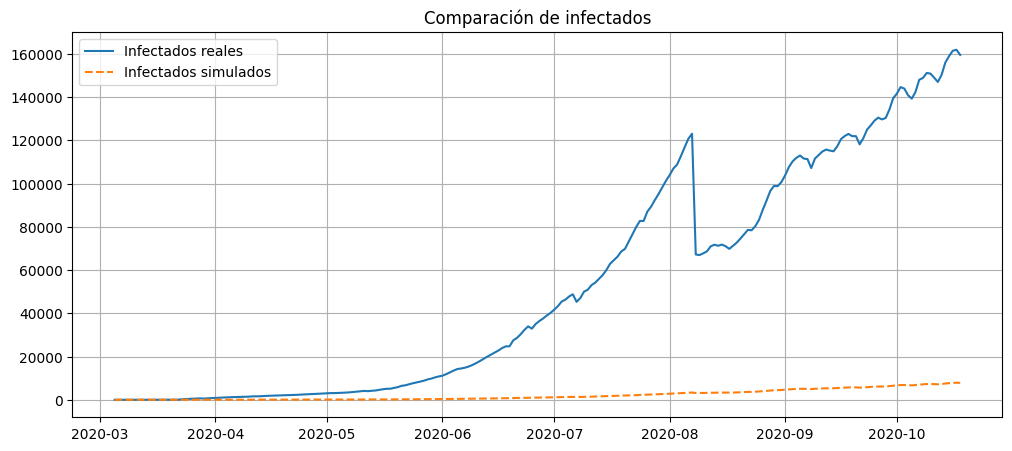

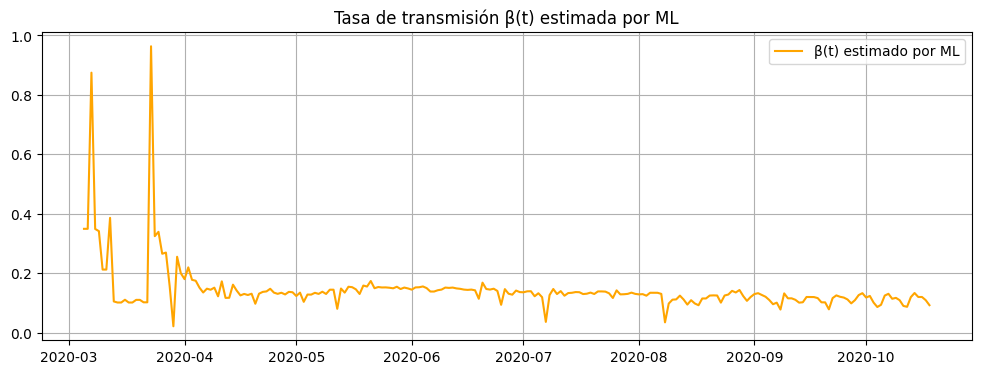

In [68]:
if __name__ == "__main__":
    df = cargar_datos()
    modelo_ml, beta_pred = entrenar_ml_para_beta(df)
    evaluar_modelo(df, beta_pred)


MSE Infectados: 1642492024.82
MSE Recuperados: 20576028832.80
R0 promedio estimado: 2.12


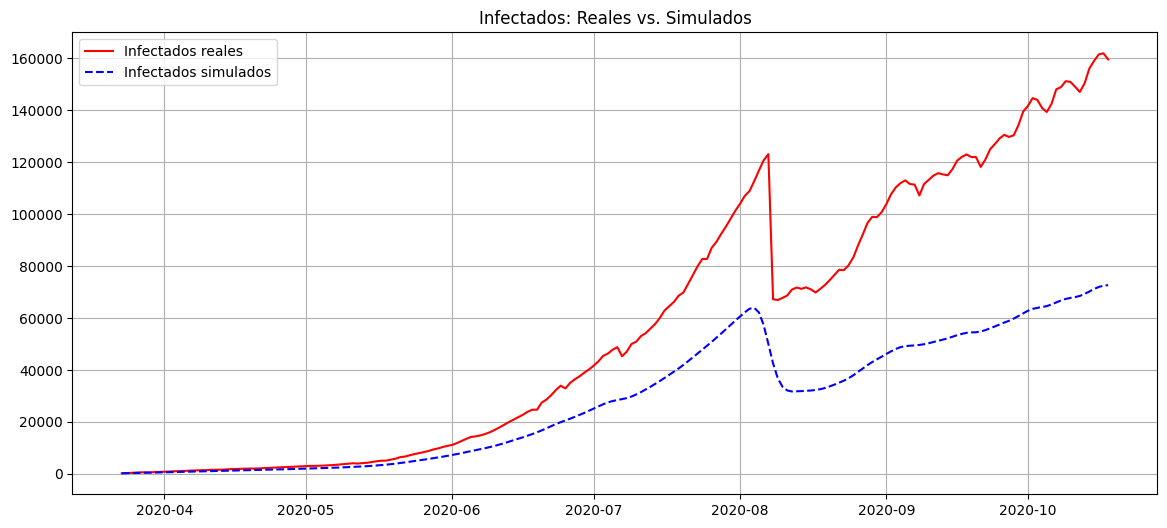

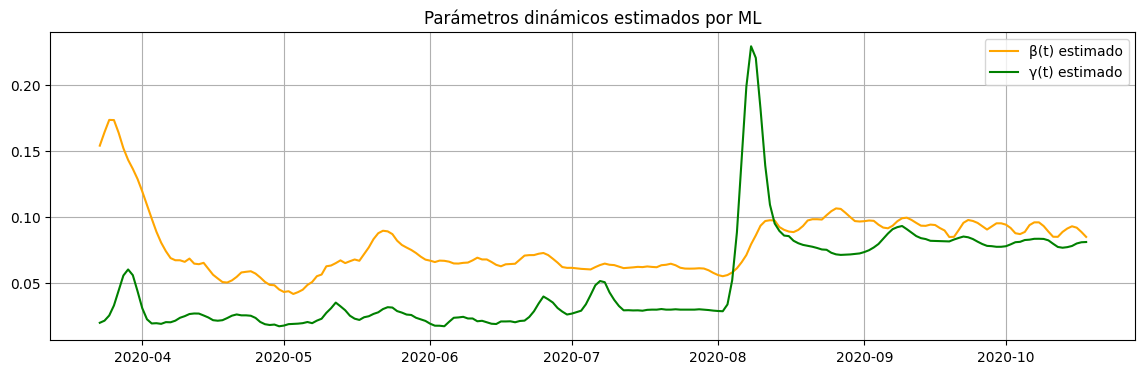

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d

# =============================
# 1. CARGA Y PREPROCESAMIENTO
# =============================
def cargar_datos():
    df_nac = pd.read_csv("Argentina-covid19.csv", parse_dates=["fecha"])
    df_prov = pd.read_csv("Argentina-covid19-por-provincia.csv", parse_dates=["fecha"])
    df_fall = pd.read_csv("Argentina-covid19-fallecidos.csv", parse_dates=["fecha"])

    df_nac['UTI_%Nacion'] = df_nac['UTI_%Nacion'].astype(str).str.replace(',', '.').astype(float)
    df_nac['edad_prom'] = df_nac['edad_prom'].astype(str).str.replace(',', '.').astype(float)

    df_prov_agg = df_prov.groupby('fecha').agg({
        'casos_nuevos': 'sum',
        'muertes_nuevos': 'sum'
    }).add_suffix('_prov')

    df_fall['edad'] = pd.to_numeric(df_fall['edad'], errors='coerce')
    edad_stats = df_fall.groupby('fecha')['edad'].agg(['mean']).rename(columns={'mean': 'edad_mean'})

    df = df_nac.merge(df_prov_agg, on='fecha', how='left')
    df = df.merge(edad_stats, on='fecha', how='left')

    df['I'] = df['casos_total'] - df['alta_total'] - df['muertes_total']
    df['R'] = df['alta_total'] + df['muertes_total']
    df['S'] = 45_000_000 - df['I'] - df['R']
    df['positividad'] = df['casos_nuevos'] / df['tests_realizados_nuevos'].replace(0, np.nan)
    df['gravedad'] = df['UTI_internados'] / df['activos'].replace(0, np.nan)

    df = df.fillna(method='ffill').fillna(0)
    df = df[df['I'] > 100]  # Umbral mínimo de casos activos
    df = df.reset_index(drop=True)
    return df

# =============================
# 2. SIMULADOR SIR MEJORADO
# =============================
def simular_sir(beta_t, gamma_t, df):
    N = 45_000_000
    S, I, R = [df['S'].iloc[0]], [df['I'].iloc[0]], [df['R'].iloc[0]]

    for t in range(1, len(df)):
        beta = beta_t[t]
        gamma = gamma_t[t]
        dS = -beta * S[-1] * I[-1] / N
        dI = beta * S[-1] * I[-1] / N - gamma * I[-1]
        dR = gamma * I[-1]

        S.append(S[-1] + dS)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)

    return np.array(S), np.array(I), np.array(R)

# =============================
# 3. ENTRENAMIENTO ML PARA BETA Y GAMMA
# =============================
def entrenar_modelos(df):
    I = df['I'].values
    R = df['R'].values
    dI = np.diff(I, prepend=I[0])
    dR = np.diff(R, prepend=R[0])

    beta_emp = (dI + dR) * 45_000_000 / (df['S'].values * I + 1e-8)
    gamma_emp = dR / (I + 1e-8)

    beta_emp = gaussian_filter1d(np.clip(beta_emp, 0, 1.5), sigma=2)
    gamma_emp = gaussian_filter1d(np.clip(gamma_emp, 0, 1.0), sigma=2)

    features = ['dia_cuarentena', 'positividad', 'gravedad', 'edad_mean', 'casos_nuevos_prov', 'UTI_%Nacion']
    X = df[features].fillna(0)

    model_beta = GradientBoostingRegressor(n_estimators=100, max_depth=4)
    model_gamma = GradientBoostingRegressor(n_estimators=100, max_depth=4)

    model_beta.fit(X, beta_emp)
    model_gamma.fit(X, gamma_emp)

    beta_pred = model_beta.predict(X)
    gamma_pred = model_gamma.predict(X)

    return model_beta, model_gamma, beta_pred, gamma_pred

# =============================
# 4. VISUALIZACIÓN Y EVALUACIÓN
# =============================
def evaluar_y_graficar(df, beta_t, gamma_t):
    S_sim, I_sim, R_sim = simular_sir(beta_t, gamma_t, df)

    mse_I = mean_squared_error(df['I'], I_sim)
    mse_R = mean_squared_error(df['R'], R_sim)

    print(f"MSE Infectados: {mse_I:.2f}")
    print(f"MSE Recuperados: {mse_R:.2f}")
    print(f"R0 promedio estimado: {np.mean(beta_t / gamma_t):.2f}")

    plt.figure(figsize=(14, 6))
    plt.plot(df['fecha'], df['I'], label='Infectados reales', color='red')
    plt.plot(df['fecha'], I_sim, label='Infectados simulados', linestyle='--', color='blue')
    plt.legend()
    plt.title("Infectados: Reales vs. Simulados")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(df['fecha'], beta_t, label='β(t) estimado', color='orange')
    plt.plot(df['fecha'], gamma_t, label='γ(t) estimado', color='green')
    plt.legend()
    plt.title("Parámetros dinámicos estimados por ML")
    plt.grid(True)
    plt.show()

# =============================
# 5. MAIN
# =============================
if __name__ == "__main__":
    df = cargar_datos()
    model_beta, model_gamma, beta_pred, gamma_pred = entrenar_modelos(df)
    evaluar_y_graficar(df, beta_pred, gamma_pred)


MSE Infectados: 1702065958.23
MSE Recuperados: 20602610783.93
R0 promedio estimado: 2.28


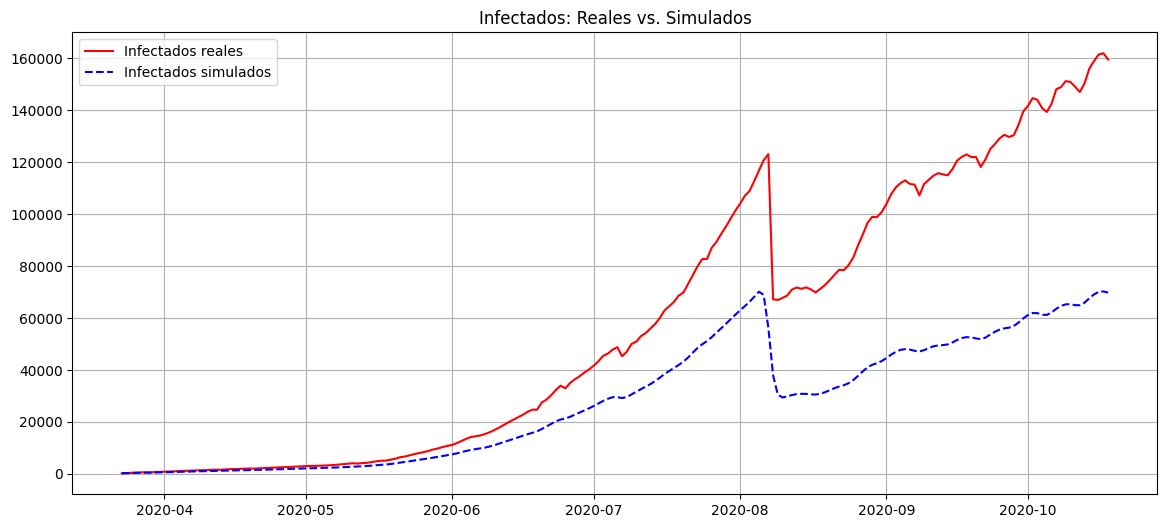

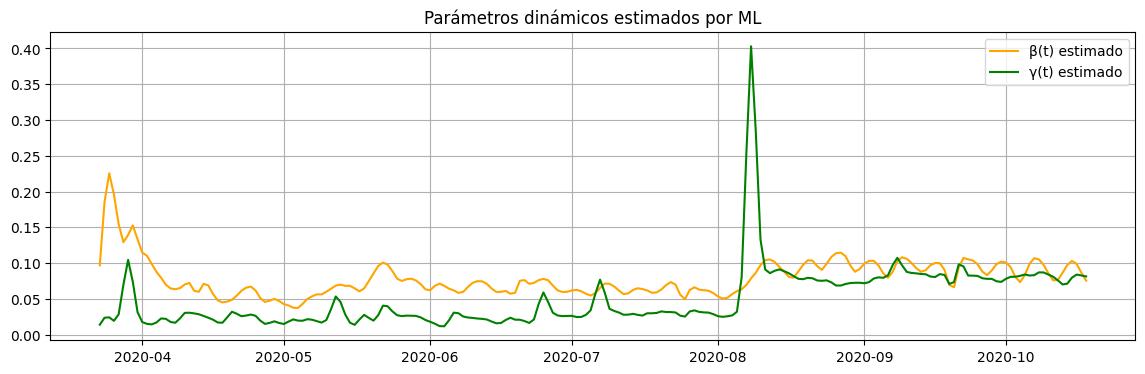

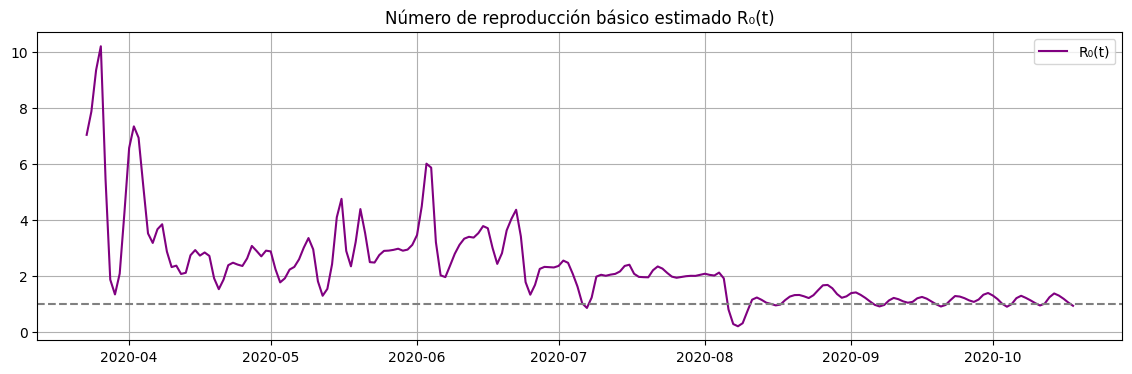

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d

# =============================
# 1. CARGA Y PREPROCESAMIENTO
# =============================
def cargar_datos():
    df_nac = pd.read_csv("Argentina-covid19.csv", parse_dates=["fecha"])
    df_prov = pd.read_csv("Argentina-covid19-por-provincia.csv", parse_dates=["fecha"])
    df_fall = pd.read_csv("Argentina-covid19-fallecidos.csv", parse_dates=["fecha"])

    df_nac['UTI_%Nacion'] = df_nac['UTI_%Nacion'].astype(str).str.replace(',', '.').astype(float)
    df_nac['edad_prom'] = df_nac['edad_prom'].astype(str).str.replace(',', '.').astype(float)

    df_prov_agg = df_prov.groupby('fecha').agg({
        'casos_nuevos': 'sum',
        'muertes_nuevos': 'sum'
    }).add_suffix('_prov')

    df_fall['edad'] = pd.to_numeric(df_fall['edad'], errors='coerce')
    edad_stats = df_fall.groupby('fecha')['edad'].agg(['mean']).rename(columns={'mean': 'edad_mean'})

    df = df_nac.merge(df_prov_agg, on='fecha', how='left')
    df = df.merge(edad_stats, on='fecha', how='left')

    df['I'] = df['casos_total'] - df['alta_total'] - df['muertes_total']
    df['R'] = df['alta_total'] + df['muertes_total']
    df['S'] = 45_000_000 - df['I'] - df['R']
    df['positividad'] = df['casos_nuevos'] / df['tests_realizados_nuevos'].replace(0, np.nan)
    df['gravedad'] = df['UTI_internados'] / df['activos'].replace(0, np.nan)

    df = df.fillna(method='ffill').fillna(0)
    df = df[df['I'] > 100]  # Umbral mínimo de casos activos
    df = df.reset_index(drop=True)

    # Añadimos una variable útil para los modelos
    df['dia_cuarentena'] = np.arange(len(df))

    return df

# =============================
# 2. SIMULADOR SIR MEJORADO
# =============================
def simular_sir(beta_t, gamma_t, df):
    N = 45_000_000
    S, I, R = [df['S'].iloc[0]], [df['I'].iloc[0]], [df['R'].iloc[0]]

    for t in range(1, len(df)):
        beta = beta_t[t]
        gamma = gamma_t[t]
        dS = -beta * S[-1] * I[-1] / N
        dI = beta * S[-1] * I[-1] / N - gamma * I[-1]
        dR = gamma * I[-1]

        S.append(S[-1] + dS)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)

    return np.array(S), np.array(I), np.array(R)

# =============================
# 3. ENTRENAMIENTO ML PARA BETA Y GAMMA
# =============================
def entrenar_modelos(df):
    I = df['I'].values
    R = df['R'].values
    dI = np.diff(I, prepend=I[0])
    dR = np.diff(R, prepend=R[0])

    beta_emp = (dI + dR) * 45_000_000 / (df['S'].values * I + 1e-8)
    gamma_emp = dR / (I + 1e-8)

    # AJUSTE: suavizado más leve y rangos ampliados
    beta_emp = gaussian_filter1d(np.clip(beta_emp, 0, 2.5), sigma=1)
    gamma_emp = gaussian_filter1d(np.clip(gamma_emp, 0, 1.2), sigma=1)

    # Variables explicativas (puedes agregar más si las tenés)
    features = ['dia_cuarentena', 'positividad', 'gravedad', 'edad_mean', 'casos_nuevos_prov', 'UTI_%Nacion']
    X = df[features].fillna(0)

    # AJUSTE: modelos más complejos
    model_beta = GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05)
    model_gamma = GradientBoostingRegressor(n_estimators=300, max_depth=6, learning_rate=0.05)

    model_beta.fit(X, beta_emp)
    model_gamma.fit(X, gamma_emp)

    beta_pred = model_beta.predict(X)
    gamma_pred = model_gamma.predict(X)

    return model_beta, model_gamma, beta_pred, gamma_pred

# =============================
# 4. VISUALIZACIÓN Y EVALUACIÓN
# =============================
def evaluar_y_graficar(df, beta_t, gamma_t):
    S_sim, I_sim, R_sim = simular_sir(beta_t, gamma_t, df)

    mse_I = mean_squared_error(df['I'], I_sim)
    mse_R = mean_squared_error(df['R'], R_sim)

    print(f"MSE Infectados: {mse_I:.2f}")
    print(f"MSE Recuperados: {mse_R:.2f}")
    print(f"R0 promedio estimado: {np.mean(beta_t / gamma_t):.2f}")

    plt.figure(figsize=(14, 6))
    plt.plot(df['fecha'], df['I'], label='Infectados reales', color='red')
    plt.plot(df['fecha'], I_sim, label='Infectados simulados', linestyle='--', color='blue')
    plt.legend()
    plt.title("Infectados: Reales vs. Simulados")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(df['fecha'], beta_t, label='β(t) estimado', color='orange')
    plt.plot(df['fecha'], gamma_t, label='γ(t) estimado', color='green')
    plt.legend()
    plt.title("Parámetros dinámicos estimados por ML")
    plt.grid(True)
    plt.show()

    # Adicional: R0 en el tiempo
    R0_t = beta_t / gamma_t
    plt.figure(figsize=(14, 4))
    plt.plot(df['fecha'], R0_t, label='R₀(t)', color='purple')
    plt.axhline(1.0, color='gray', linestyle='--')
    plt.legend()
    plt.title("Número de reproducción básico estimado R₀(t)")
    plt.grid(True)
    plt.show()

# =============================
# 5. MAIN
# =============================
if __name__ == "__main__":
    df = cargar_datos()
    model_beta, model_gamma, beta_pred, gamma_pred = entrenar_modelos(df)
    evaluar_y_graficar(df, beta_pred, gamma_pred)



--- Métricas del modelo ---
MSE Infectados: 524,769,387
R² Infectados: 0.803
MSE Recuperados: 6,782,733,182
R² Recuperados: 0.880
R0 promedio estimado: 2.17


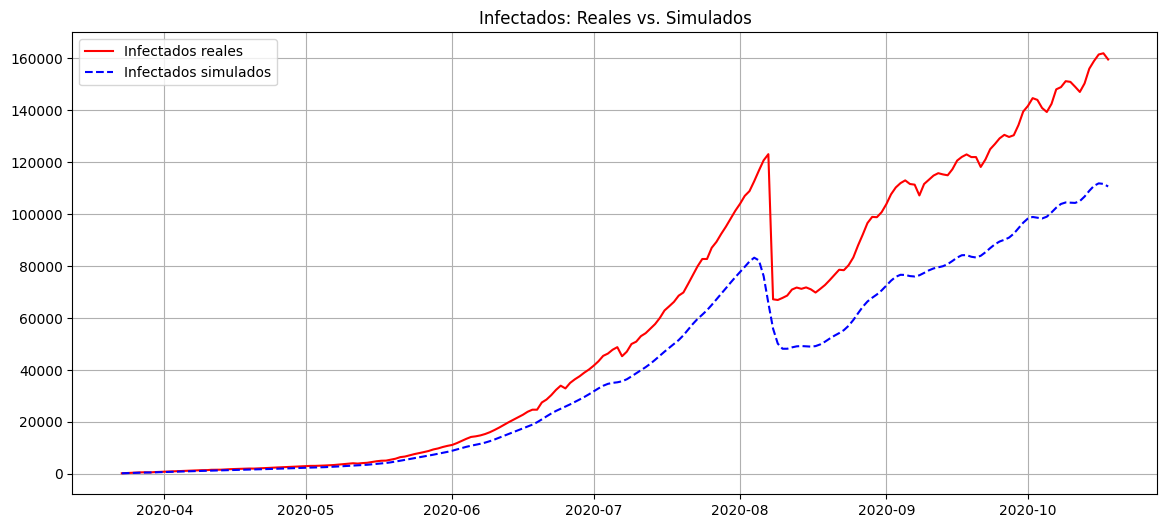

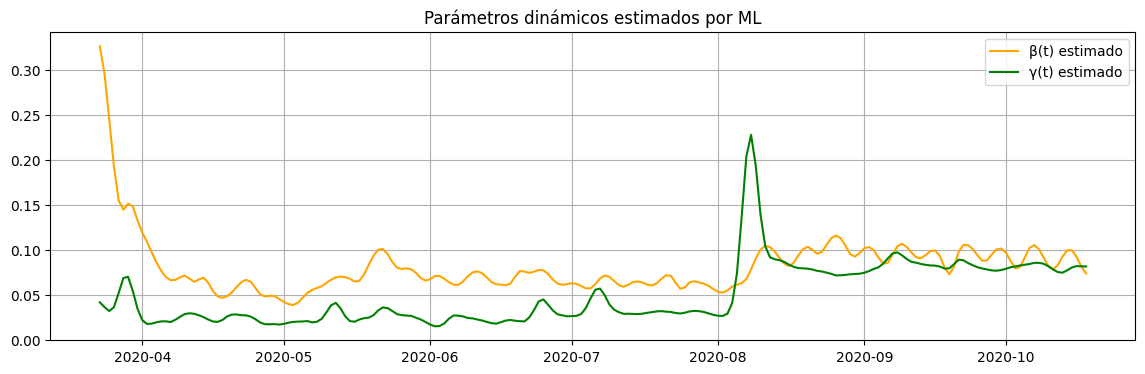

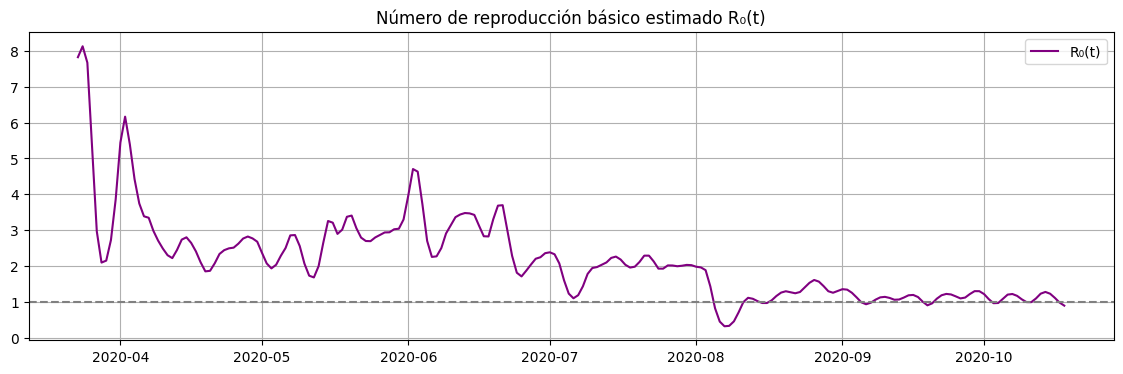

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.ndimage import gaussian_filter1d

# =============================
# 1. CARGA Y PREPROCESAMIENTO
# =============================
def cargar_datos():
    df_nac = pd.read_csv("Argentina-covid19.csv", parse_dates=["fecha"])
    df_prov = pd.read_csv("Argentina-covid19-por-provincia.csv", parse_dates=["fecha"])
    df_fall = pd.read_csv("Argentina-covid19-fallecidos.csv", parse_dates=["fecha"])

    df_nac['UTI_%Nacion'] = df_nac['UTI_%Nacion'].astype(str).str.replace(',', '.').astype(float)
    df_nac['edad_prom'] = df_nac['edad_prom'].astype(str).str.replace(',', '.').astype(float)

    df_prov_agg = df_prov.groupby('fecha').agg({
        'casos_nuevos': 'sum',
        'muertes_nuevos': 'sum'
    }).add_suffix('_prov')

    df_fall['edad'] = pd.to_numeric(df_fall['edad'], errors='coerce')
    edad_stats = df_fall.groupby('fecha')['edad'].agg(['mean']).rename(columns={'mean': 'edad_mean'})

    df = df_nac.merge(df_prov_agg, on='fecha', how='left')
    df = df.merge(edad_stats, on='fecha', how='left')

    df['I'] = df['casos_total'] - df['alta_total'] - df['muertes_total']
    df['R'] = df['alta_total'] + df['muertes_total']
    df['S'] = 45_000_000 - df['I'] - df['R']
    df['positividad'] = df['casos_nuevos'] / df['tests_realizados_nuevos'].replace(0, np.nan)
    df['gravedad'] = df['UTI_internados'] / df['activos'].replace(0, np.nan)

    df = df.fillna(method='ffill').fillna(0)
    df = df[df['I'] > 100]
    df = df.reset_index(drop=True)

    df['dia_cuarentena'] = np.arange(len(df))

    return df

# =============================
# 2. SIMULADOR SIR
# =============================
def simular_sir(beta_t, gamma_t, df):
    N = 45_000_000
    S, I, R = [df['S'].iloc[0]], [df['I'].iloc[0]], [df['R'].iloc[0]]

    for t in range(1, len(df)):
        beta = beta_t[t]
        gamma = gamma_t[t]
        dS = -beta * S[-1] * I[-1] / N
        dI = beta * S[-1] * I[-1] / N - gamma * I[-1]
        dR = gamma * I[-1]

        S.append(S[-1] + dS)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)

    return np.array(S), np.array(I), np.array(R)

# =============================
# 3. ENTRENAMIENTO ML
# =============================
def entrenar_modelos(df):
    I = df['I'].values
    R = df['R'].values
    dI = np.gradient(I)
    dR = np.gradient(R)

    beta_emp = (dI + dR) * 45_000_000 / (df['S'].values * I + 1e-8)
    gamma_emp = dR / (I + 1e-8)

    beta_emp = gaussian_filter1d(np.clip(beta_emp, 0, 3.0), sigma=1.2)
    gamma_emp = gaussian_filter1d(np.clip(gamma_emp, 0, 1.5), sigma=1.5)

    df['mes'] = df['fecha'].dt.month
    df['semana'] = df['fecha'].dt.isocalendar().week.astype(int)
    df['tendencia_I'] = pd.Series(I).rolling(window=5, min_periods=1).mean()

    features = [
        'dia_cuarentena', 'positividad', 'gravedad', 'edad_mean',
        'casos_nuevos_prov', 'UTI_%Nacion', 'mes', 'semana', 'tendencia_I'
    ]
    X = df[features].fillna(0)

    model_beta = GradientBoostingRegressor(n_estimators=500, max_depth=7, learning_rate=0.03, subsample=0.8)
    model_gamma = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=0.03, subsample=0.8)

    model_beta.fit(X, beta_emp)
    model_gamma.fit(X, gamma_emp)

    beta_pred = model_beta.predict(X)
    gamma_pred = model_gamma.predict(X)

    return model_beta, model_gamma, beta_pred, gamma_pred

# =============================
# 4. MÉTRICAS Y GRAFICACIÓN
# =============================
def mostrar_metricas(df, I_sim, R_sim):
    print("\n--- Métricas del modelo ---")
    print(f"MSE Infectados: {mean_squared_error(df['I'], I_sim):,.0f}")
    print(f"R² Infectados: {r2_score(df['I'], I_sim):.3f}")
    print(f"MSE Recuperados: {mean_squared_error(df['R'], R_sim):,.0f}")
    print(f"R² Recuperados: {r2_score(df['R'], R_sim):.3f}")

def evaluar_y_graficar(df, beta_t, gamma_t):
    S_sim, I_sim, R_sim = simular_sir(beta_t, gamma_t, df)

    mostrar_metricas(df, I_sim, R_sim)
    print(f"R0 promedio estimado: {np.mean(beta_t / gamma_t):.2f}")

    plt.figure(figsize=(14, 6))
    plt.plot(df['fecha'], df['I'], label='Infectados reales', color='red')
    plt.plot(df['fecha'], I_sim, label='Infectados simulados', linestyle='--', color='blue')
    plt.legend()
    plt.title("Infectados: Reales vs. Simulados")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(df['fecha'], beta_t, label='β(t) estimado', color='orange')
    plt.plot(df['fecha'], gamma_t, label='γ(t) estimado', color='green')
    plt.legend()
    plt.title("Parámetros dinámicos estimados por ML")
    plt.grid(True)
    plt.show()

    R0_t = beta_t / gamma_t
    plt.figure(figsize=(14, 4))
    plt.plot(df['fecha'], R0_t, label='R₀(t)', color='purple')
    plt.axhline(1.0, color='gray', linestyle='--')
    plt.legend()
    plt.title("Número de reproducción básico estimado R₀(t)")
    plt.grid(True)
    plt.show()

# =============================
# 5. MAIN
# =============================
if __name__ == "__main__":
    df = cargar_datos()
    model_beta, model_gamma, beta_pred, gamma_pred = entrenar_modelos(df)
    evaluar_y_graficar(df, beta_pred, gamma_pred)


In [83]:
def mostrar_importancia_caracteristicas(model, nombre_modelo, features):
    importancias = model.feature_importances_
    print(f"\nImportancia de características en el modelo {nombre_modelo}:")
    for f, imp in sorted(zip(features, importancias), key=lambda x: x[1], reverse=True):
        print(f"  {f}: {imp:.4f}")

# En tu código, después de entrenar los modelos:
features = [
    'dia_cuarentena', 'positividad', 'gravedad', 'edad_mean',
    'casos_nuevos_prov', 'UTI_%Nacion', 'mes', 'semana', 'tendencia_I'
]

mostrar_importancia_caracteristicas(model_beta, "Beta", features)
mostrar_importancia_caracteristicas(model_gamma, "Gamma", features)



Importancia de características en el modelo Beta:
  dia_cuarentena: 0.4972
  tendencia_I: 0.3205
  mes: 0.0430
  positividad: 0.0289
  UTI_%Nacion: 0.0274
  semana: 0.0257
  gravedad: 0.0235
  casos_nuevos_prov: 0.0226
  edad_mean: 0.0112

Importancia de características en el modelo Gamma:
  dia_cuarentena: 0.7839
  UTI_%Nacion: 0.0880
  semana: 0.0290
  gravedad: 0.0286
  casos_nuevos_prov: 0.0283
  tendencia_I: 0.0264
  positividad: 0.0096
  edad_mean: 0.0037
  mes: 0.0025


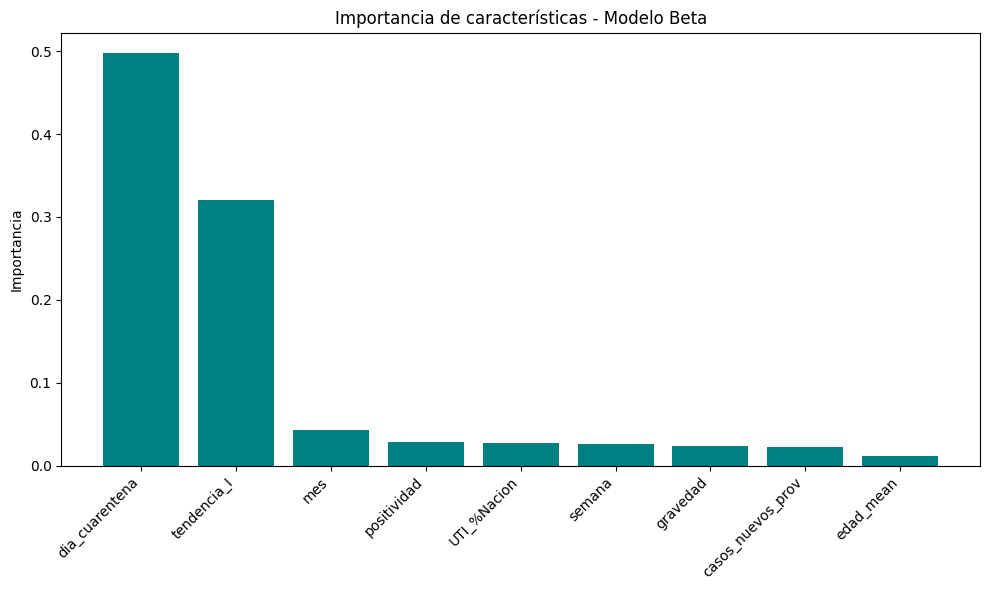

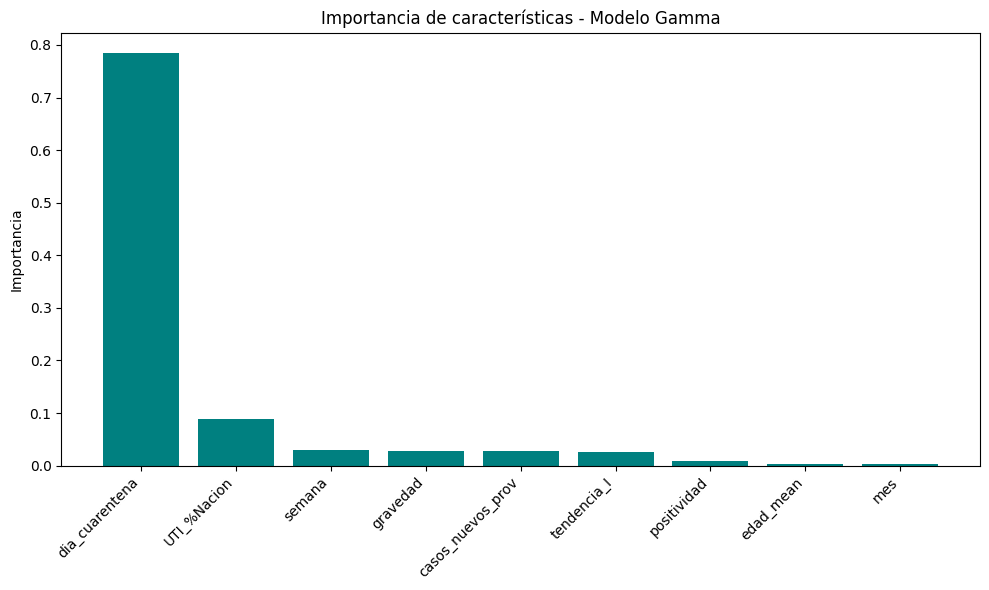

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_importancia_caracteristicas(model, nombre_modelo, features):
    importancias = model.feature_importances_
    indices = np.argsort(importancias)[::-1]  # Orden descendente

    plt.figure(figsize=(10,6))
    plt.title(f'Importancia de características - Modelo {nombre_modelo}')
    plt.bar(range(len(features)), importancias[indices], color='teal', align='center')
    plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45, ha='right')
    plt.ylabel('Importancia')
    plt.tight_layout()
    plt.show()

# Ejemplo de uso luego de entrenar:
graficar_importancia_caracteristicas(model_beta, "Beta", features)
graficar_importancia_caracteristicas(model_gamma, "Gamma", features)
